# Импорт библиотек

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import re
from tqdm.notebook import tqdm
tqdm.pandas()

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (cross_val_score,
                                     TimeSeriesSplit)
from sklearn.metrics import (mean_absolute_error,
                             make_scorer)
from sklearn.pipeline import (Pipeline,
                              make_pipeline)
from sklearn.preprocessing import (OneHotEncoder,
                                   StandardScaler)
from sklearn.compose import ColumnTransformer

# Глобальные переменные

In [7]:
RANDOM_STATE = 123

# Загрузка данных

In [8]:
train_df = pd.read_csv('train_dataset.csv')

In [9]:
test_df = pd.read_csv('test_dataset.csv')

# EDA, предобработка

In [10]:
train_df.head(3)

,date,time,target,temp,temp_pred,weather_pred,weather_fact
0,2019-01-01,0,481.510,2.9,2.0,"пасм, ветер",ветер
1,2019-01-01,1,462.872,2.9,2.0,"пасм, ветер",ветер
2,2019-01-01,2,449.718,2.9,2.0,"пасм, ветер",ветер


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37224 entries, 0 to 37223
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          37224 non-null  object 
 1   time          37224 non-null  int64  
 2   target        37224 non-null  float64
 3   temp          37224 non-null  float64
 4   temp_pred     37136 non-null  float64
 5   weather_pred  37136 non-null  object 
 6   weather_fact  37223 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 2.0+ MB


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2928 entries, 0 to 2927
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          2928 non-null   object 
 1   time          2928 non-null   int64  
 2   target        2928 non-null   float64
 3   temp          2928 non-null   float64
 4   temp_pred     2904 non-null   float64
 5   weather_pred  2904 non-null   object 
 6   weather_fact  2928 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 160.2+ KB


___
Пропуски в temp_pred и weather_pred
___

In [13]:
# джойним дату и время в один признак

# train
train_df['date_time'] = pd.to_datetime(train_df['date'] + ' ' + train_df['time'].astype(str) + ':00')

# test
test_df['date_time'] = pd.to_datetime(test_df['date'] + ' ' + test_df['time'].astype(str) + ':00')

In [14]:
# дату установим как индекс df

# train
train_df = train_df.set_index('date_time').sort_index()

# test
test_df = test_df.set_index('date_time').sort_index()

In [15]:
test_index = test_df.index

## проверка временного ряда на стационарность

- $H_0$ - временной ряд является нестационарным.
- $H_1$ - временной ряд является стационарным.

$\alpha$ = 0.05

In [16]:
alpha = 0.05

In [17]:
dfuller_test = adfuller(train_df['target'])

In [18]:
print(f'p-value: {dfuller_test[1]:.6f}')
if dfuller_test[1] > alpha:
    print("Не можем отвергнуть нулевую гипотезу, ряд не стационарен")
    
else:
    print("Отвергаем нулевую гипотезу, ряд стационарен")

p-value: 0.000264
Отвергаем нулевую гипотезу, ряд стационарен


## ресэмплирование

In [19]:
# ресэмплирование

train_df_1d = pd.DataFrame(train_df['target'].resample('1d').sum())
train_df_1w = train_df['target'].resample('1w').sum()
train_df_1m = train_df['target'].resample('1m').sum()

In [20]:
decomposed_1d = seasonal_decompose(train_df_1d)
decomposed_1w = seasonal_decompose(train_df_1w)
decomposed_1m = seasonal_decompose(train_df_1m)

##  df агрегированный за 1 день

In [21]:
train_df_agg = train_df.groupby('date').agg({'target':sum, 'temp':'mean', 'temp_pred':'mean'})

In [22]:
# выделим временные признаки

train_df_agg.index = pd.to_datetime(train_df_agg.index)

train_df_agg['day_number'] =  train_df_agg.index.day
train_df_agg['day_name'] = train_df_agg.index.day_name()
train_df_agg['month_name'] = train_df_agg.index.month_name()
train_df_agg['week_number'] = train_df_agg.index.isocalendar().week

## тренд

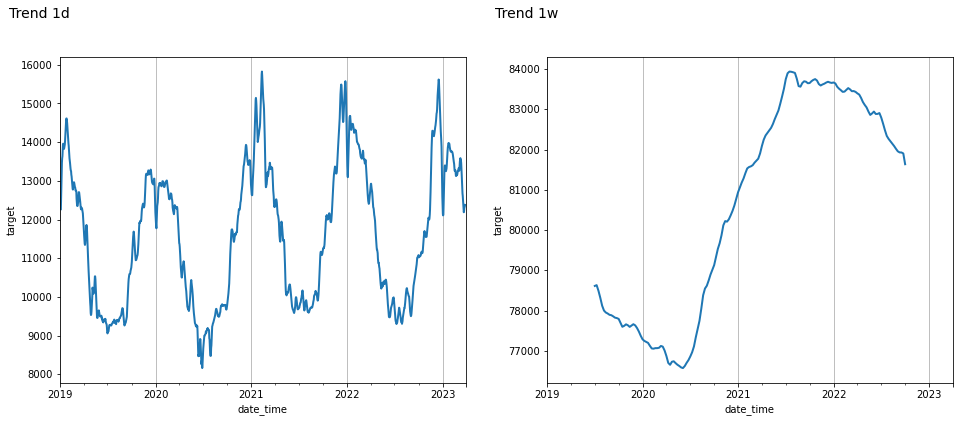

In [23]:
fig, ax = plt.subplots(figsize=(16, 6))

plt.subplot(1, 2, 1)
decomposed_1d.trend.plot(ax=plt.gca(), linewidth=2)
plt.title('Trend 1d', x = -0.05, y = 1.1, size=14)
plt.ylabel('target')
plt.grid(axis='x')

plt.subplot(1, 2, 2)
decomposed_1w.trend.plot(ax=plt.gca(), linewidth=2)
plt.title('Trend 1w', x = -0.05, y = 1.1, size=14)
plt.ylabel('target')
plt.grid(axis='x');

## сезонность

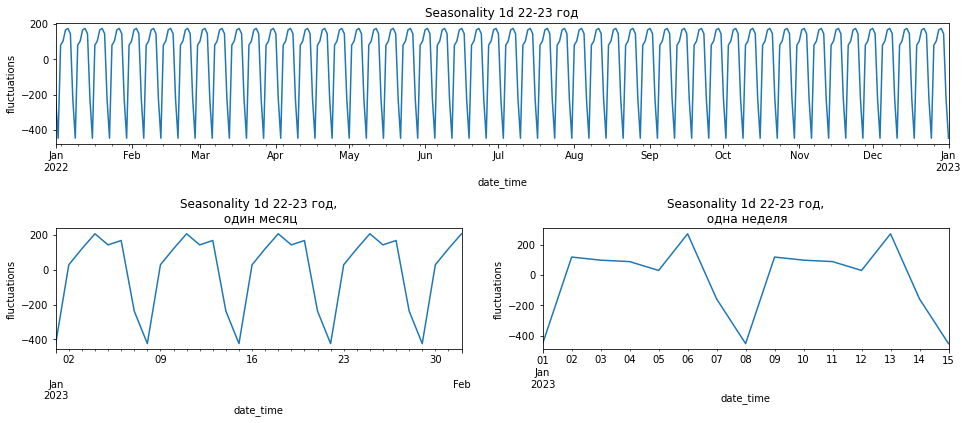

In [24]:
# дневной таймфрейм

fig, ax = plt.subplots(figsize=(16, 6))

TITLE_Y_POS = 1.
TITLE_SIZE = 12

plt.subplot(2, 1, 1)
decomposed_1d_22_23 = seasonal_decompose(train_df_1d['2022/01/01':'2023/01/01'])
decomposed_1d_22_23.seasonal.plot() 
plt.title('Seasonality 1d 22-23 год', y = TITLE_Y_POS, size=TITLE_SIZE)
plt.ylabel('fluctuations')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.subplot(2, 2, 3)
decomposed_1d_22_23_month = seasonal_decompose(train_df_1d['2023/01/01':'2023/02/01'])
decomposed_1d_22_23_month.seasonal.plot() 
plt.title('Seasonality 1d 22-23 год,\n один месяц', y = TITLE_Y_POS, size=TITLE_SIZE)
plt.ylabel('fluctuations')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.subplot(2, 2, 4)
decomposed_1d_22_23_week = seasonal_decompose(train_df_1d['2023/01/01':'2023/01/15'])
decomposed_1d_22_23_week.seasonal.plot() 
plt.title('Seasonality 1d 22-23 год,\n одна неделя', y = TITLE_Y_POS, size=TITLE_SIZE)
plt.ylabel('fluctuations')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.subplots_adjust(hspace=0.7);

___
- недельная цикличность
___

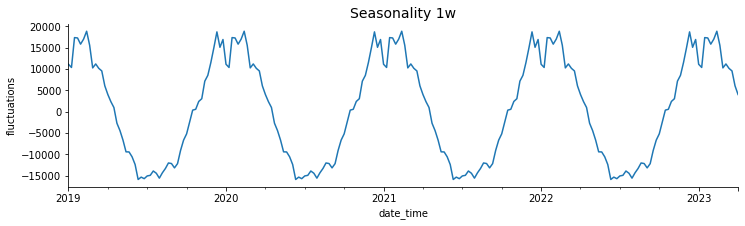

In [25]:
# недельный таймфрейм

fig, ax = plt.subplots(figsize=(12, 3))

decomposed_1w.seasonal.plot() 
plt.title('Seasonality 1w', y = TITLE_Y_POS, size=14)
plt.ylabel('fluctuations')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

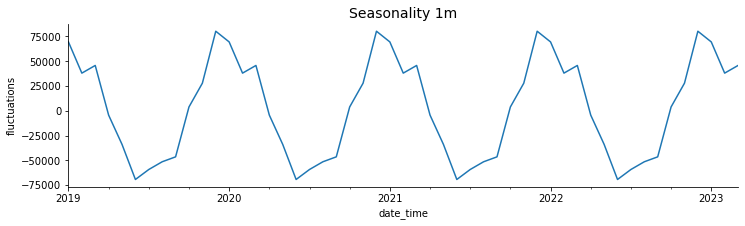

In [26]:
# месячный таймфрейм

fig, ax = plt.subplots(figsize=(12, 3))

decomposed_1m.seasonal.plot() 
plt.title('Seasonality 1m', y = TITLE_Y_POS, size=14)
plt.ylabel('fluctuations')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

___
- годовая цикличность
___

## необъясненные остатки

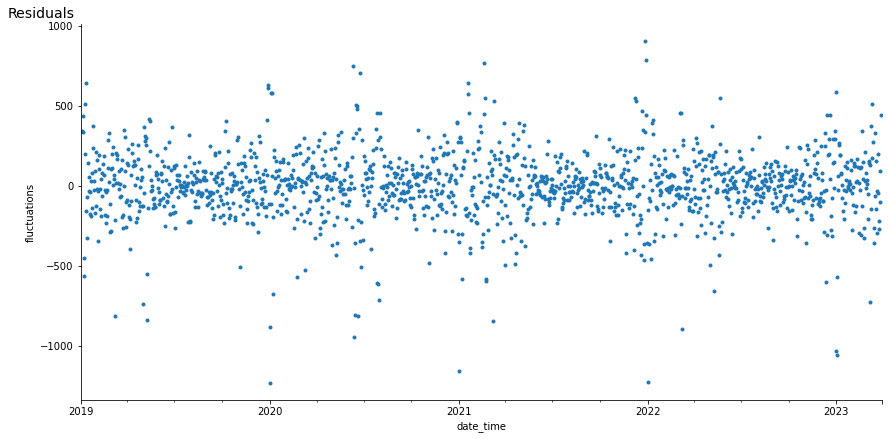

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))

decomposed_1d.resid.plot(style='.') 
plt.tight_layout()
plt.title('Residuals', x = -0.05, y = 1.1, size=14)
plt.ylabel('fluctuations')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

In [28]:
resid = decomposed_1d.resid

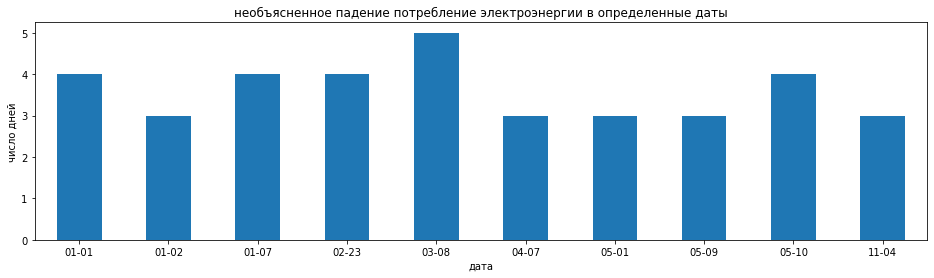

In [29]:
# необъясненное падение потребления энергии

resid_less = resid[resid <= -200]
resid_less_filtered_m_d = resid_less.index.strftime("%m-%d")
resid_less_filtered_m_d_agg = resid_less_filtered_m_d.value_counts()
resid_less_filtered_m_d_agg = resid_less_filtered_m_d_agg[resid_less_filtered_m_d_agg > 2].sort_index()

plt.figure(figsize=(16, 4))
resid_less_filtered_m_d_agg.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('необъясненное падение потребление электроэнергии в определенные даты')
plt.xlabel('дата')
plt.ylabel('число дней')
plt.yticks(np.arange(0, resid_less_filtered_m_d_agg.max() + 1));

сокращение потребления электричества в праздники:
- 01-01(1 января);
- 01-07(7 января);
- 03-08(8 марта);
- 05-09(9 мая).

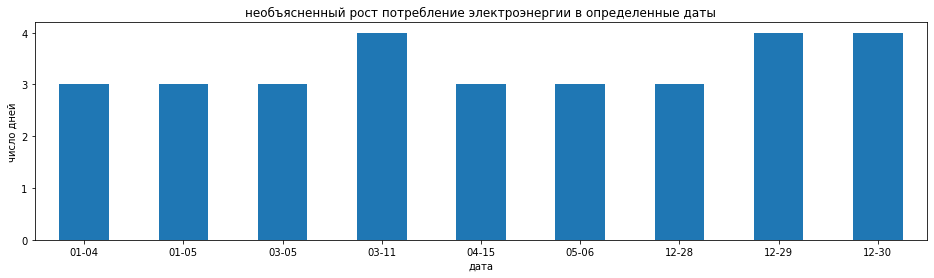

In [30]:
# необъясненный рост потребления энергии

resid_more = resid[resid >= 200]
resid_more_filtered_m_d = resid_more.index.strftime("%m-%d")
resid_more_filtered_m_d_agg = resid_more_filtered_m_d.value_counts()
resid_more_filtered_m_d_agg = resid_more_filtered_m_d_agg[resid_more_filtered_m_d_agg > 2].sort_index()

plt.figure(figsize=(16, 4))
resid_more_filtered_m_d_agg.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('необъясненный рост потребление электроэнергии в определенные даты')
plt.xlabel('дата')
plt.ylabel('число дней')
plt.yticks(np.arange(0, resid_more_filtered_m_d_agg.max() + 1));

рост потребления электричества в праздники:
- 03-11(после 8 марта);
- 12-29(перед НГ);
- 12-29(перед НГ);

In [31]:
ouliers_date_list = []
ouliers_date_list.append(resid_less_filtered_m_d_agg.index.values)
ouliers_date_list.append(resid_more_filtered_m_d_agg.index.values)
ouliers_date_list = [*ouliers_date_list[0], *ouliers_date_list[1]]
sorted(ouliers_date_list)

['01-01',
 '01-02',
 '01-04',
 '01-05',
 '01-07',
 '02-23',
 '03-05',
 '03-08',
 '03-11',
 '04-07',
 '04-15',
 '05-01',
 '05-06',
 '05-09',
 '05-10',
 '11-04',
 '12-28',
 '12-29',
 '12-30']

## moving average

In [32]:
get_years = train_df_1d.index.strftime("%Y").unique()

In [33]:
train_df_1d.tail(3)

,target
date_time,
2023-03-29,12771.077
2023-03-30,12478.985
2023-03-31,12414.945


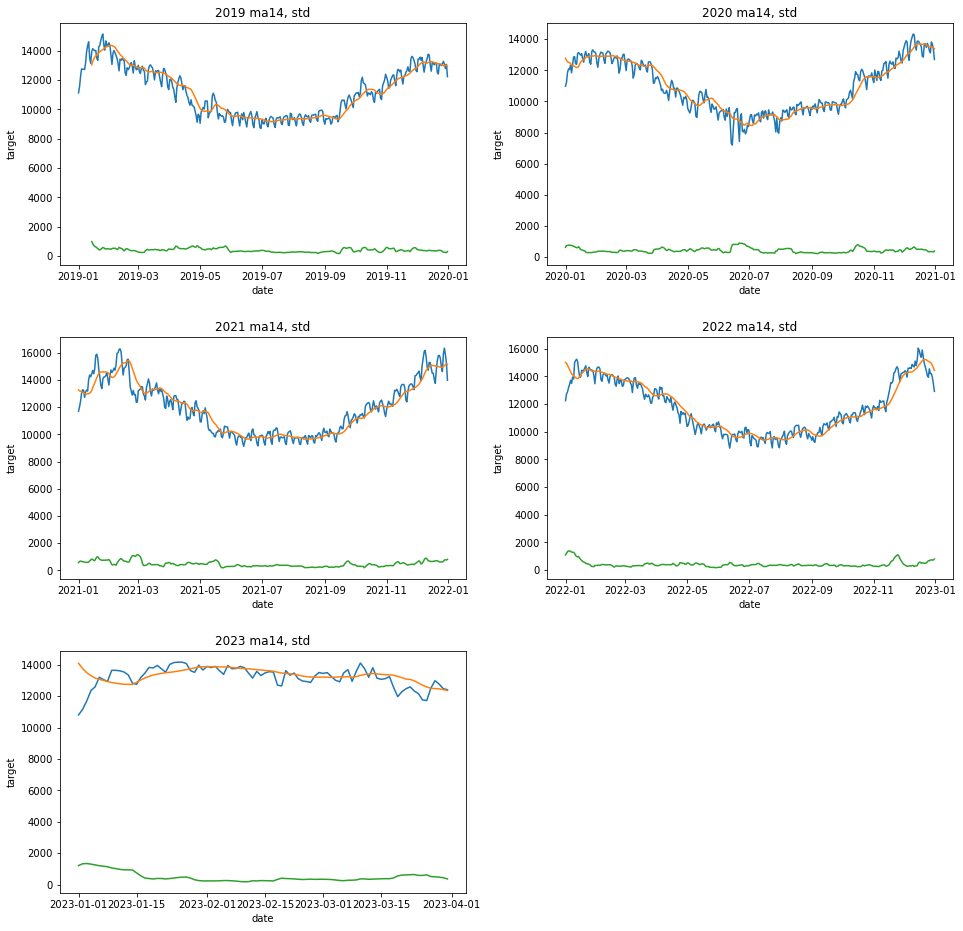

In [34]:
fig, ax = plt.subplots(figsize=(16, 16))
ROLLING = 14

graph_counter = 1

train_df_1d['ma'] = train_df_1d['target'].rolling(ROLLING).mean()
train_df_1d['std'] = train_df_1d['target'].rolling(ROLLING).std()

for y in get_years:
    plt.subplot(3, 2, graph_counter)
    
    plt.plot(train_df_1d.loc[y].index, train_df_1d.loc[y]['target'])
    plt.plot(train_df_1d.loc[y].index, train_df_1d.loc[y]['ma'])
    plt.plot(train_df_1d.loc[y].index, train_df_1d.loc[y]['std'])
    
    plt.title(y + ' ma' + str(ROLLING) + ', std', size=12)
    plt.ylabel('target')
    plt.xlabel('date')
    
    graph_counter +=1
    
    plt.subplots_adjust(hspace=0.3)

## электроэнергия - температура - прогноз темп

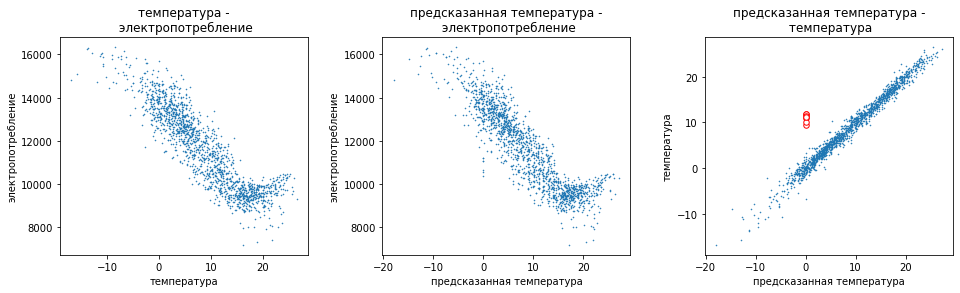

In [35]:
# связь потребления электроэнергии и температуры

plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.scatter(train_df_agg['temp'], train_df_agg['target'], s=0.3)
plt.title('температура -\n электропотребление')
plt.xlabel('температура')
plt.ylabel('электропотребление')

plt.subplot(1, 3, 2)
plt.scatter(train_df_agg['temp_pred'], train_df_agg['target'], s=0.3)
plt.title('предсказанная температура -\n электропотребление')
plt.xlabel('предсказанная температура')
plt.ylabel('электропотребление')

plt.subplot(1, 3, 3)
plt.scatter(train_df_agg['temp_pred'], train_df_agg['temp'], s=0.3)

tmp_temp = train_df_agg.query('temp_pred > -1 & temp_pred < 1  & temp > 6 ')[['temp', 'temp_pred']]
plt.scatter(tmp_temp['temp_pred'], tmp_temp['temp'], s=30, color='white', edgecolors='red')
plt.title('предсказанная температура -\n температура')
plt.xlabel('предсказанная температура')
plt.ylabel('температура')

plt.subplots_adjust(wspace=0.3);

In [36]:
train_df_agg.query('temp_pred > -2 & temp_pred < 2  & temp > 5 ')

,target,temp,temp_pred,day_number,day_name,month_name,week_number
date,,,,,,,
2022-09-25,10378.731,10.8750,0.0,25,Sunday,September,38
2022-09-26,11072.537,11.8125,0.0,26,Monday,September,39
2022-09-27,11051.553,11.8625,0.0,27,Tuesday,September,39
2022-09-30,11206.022,9.4000,0.0,30,Friday,September,39
2022-10-01,10661.154,10.0875,0.0,1,Saturday,October,39
2022-10-02,10568.353,11.4375,0.0,2,Sunday,October,39
2022-10-04,11226.123,11.2875,0.0,4,Tuesday,October,40


___
- с ростом температуры растет энергопотреблени, но, после 20 градусов начинает расти.
- видим выборосы предсказанной темперетаруты. Ошибка предсказания/восстановления.
___

## точность прогноза температуры

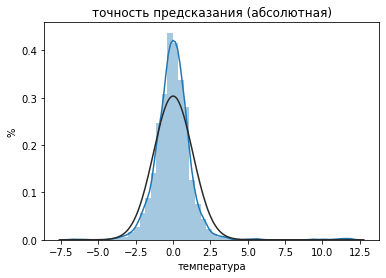

In [37]:
sns.distplot((train_df_agg['temp'] - train_df_agg['temp_pred']), fit=norm)
plt.title('точность предсказания (абсолютная)')
plt.xlabel('температура')
plt.ylabel('%');

___
ошибка предсказания температуры имеет распределение близкое к нормальному
___

## аномалии энергопотребления

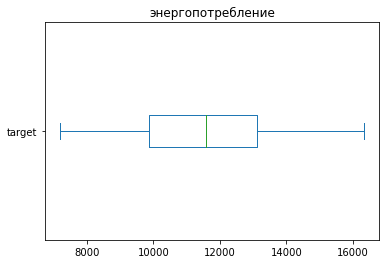

In [38]:
train_df_agg['target'].plot(kind='box', vert=False)
plt.title('энергопотребление');

___
аномалии отсутсвуют
___

## энергопотребление по дням (м, н)

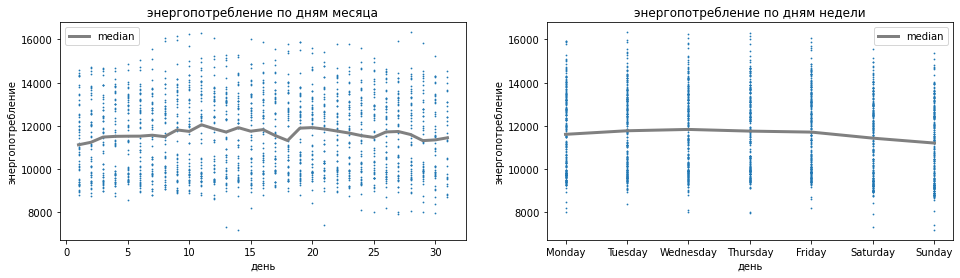

In [39]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)

plt.scatter(train_df_agg['day_number'], train_df_agg['target'], s=0.6)
plt.plot(train_df_agg.groupby('day_number').agg({'target':'median'}), color='grey', linewidth=3, label='median')
plt.title('энергопотребление по дням месяца')
plt.xlabel('день')
plt.ylabel('энергопотребление')
plt.legend()


plt.subplot(1, 2, 2)

# для сортировки дней
days_name_list = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}

plt.plot(train_df_agg.groupby('day_name').agg({'target':'median'}).sort_index(key=lambda x: x.map(days_name_list)),
        color='grey', linewidth=3, label='median')
plt.scatter(train_df_agg['day_name'], train_df_agg['target'], s=0.6)
plt.title('энергопотребление по дням недели')
plt.xlabel('день')
plt.ylabel('энергопотребление')
plt.legend();

___
- отсутсвие какой-либо динамики

## энергопотребление по месяцам, неделям

In [40]:
# для сортировки месяцев

days_name_list = dict(zip(train_df_agg['month_name'].unique(), np.arange(1, 13)))

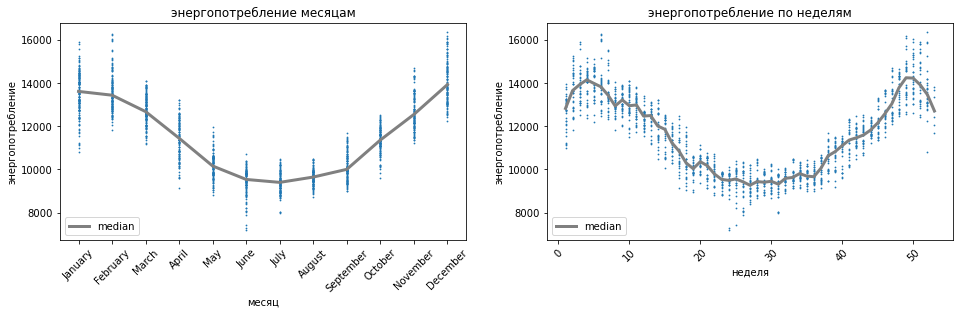

In [41]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)

plt.plot(train_df_agg.groupby('month_name').agg({'target':'median'}).sort_index(key=lambda x: x.map(days_name_list))
         , color='grey', linewidth=3, label='median')
plt.scatter(train_df_agg['month_name'], train_df_agg['target'], s=0.6)
plt.title('энергопотребление месяцам')
plt.xlabel('месяц')
plt.ylabel('энергопотребление')
plt.legend()
plt.xticks(rotation = 45)


plt.subplot(1, 2, 2)

plt.plot(train_df_agg.groupby('week_number').agg({'target':'median'})
         , color='grey', linewidth=3, label='median')
plt.scatter(train_df_agg['week_number'], train_df_agg['target'], s=0.6)
plt.title('энергопотребление по неделям')
plt.xlabel('неделя')
plt.ylabel('энергопотребление')
plt.legend()
plt.xticks(rotation = 45);

# feature engineering

## Объединяем train и test

In [42]:
train_test_df = pd.concat([train_df, test_df])

## Обрабатываем NA в temp_pred

In [43]:
na_values_index = train_test_df[train_test_df['temp_pred'].isna()].index.strftime("%Y-%m-%d").unique()
na_values_index = pd.to_datetime(na_values_index)

In [44]:
for day in na_values_index:
    try:
        # вычисляем среднюю температуру за предыдыщий день
        fix_pred_temp = train_test_df.loc[(day - pd.Timedelta(days=1)).strftime("%Y-%m-%d")]\
            .groupby('date')\
            .agg({'temp':'mean'})

        # создаем лист со значениями
        fix_pred_temp_list = np.ones(train_test_df.loc[day.strftime("%Y-%m-%d")]['temp_pred'].shape[0])*\
                                     fix_pred_temp.values[0]

        # замена
        train_test_df.loc[day.strftime("%Y-%m-%d"), ['temp_pred']] = fix_pred_temp_list
        
    except:
        train_test_df.loc[day.strftime("%Y-%m-%d")].fillna(0)

## Агрегация значений

In [45]:
train_test_df_agg = train_test_df.groupby('date').agg({'target':sum, 'temp':'mean', 'temp_pred':'mean'})

## shift, ma

In [46]:
# shift target
train_test_df_agg['target_shift_1'] = train_test_df_agg['target'].shift(1)
train_test_df_agg['target_shift_7'] = train_test_df_agg['target'].shift(7)
train_test_df_agg['target_shift_2'] = train_test_df_agg['target'].shift(2)

# shift temp
train_test_df_agg['temp_shift_1'] = train_test_df_agg['temp'].shift(1)

# ma
train_test_df_agg['ma'] = train_test_df_agg['target'].shift(1).rolling(14).mean()
train_test_df_agg['temp_ma'] = train_test_df_agg['temp'].shift(1).rolling(14).mean()

# удаляем пропуски
train_test_df_agg = train_test_df_agg.dropna(axis=0)

## временные признаки

In [47]:
# выделим временные признаки

# преобразуем inxex в dt
train_test_df_agg.index = pd.to_datetime(train_test_df_agg.index)

train_test_df_agg['day_name'] = train_test_df_agg.index.day_name()
train_test_df_agg['week_number'] = train_test_df_agg.index.isocalendar().week
train_test_df_agg['month'] = train_test_df_agg.index.month
train_test_df_agg['Q'] = train_test_df_agg.index.quarter

## праздники

In [48]:
def ouliers_date_feature(row):
    try:
        if np.isin(pd.Timestamp(row.name).strftime("%m-%d"), ouliers_date_list):
            return pd.Timestamp(row.name).strftime("%m-%d")
        else:
            return str('not_holiday_date')
    except:
        return str('not_holiday_date1')

In [49]:
train_test_df_agg['holiday_date'] = train_test_df_agg.apply(ouliers_date_feature, axis=1)

# train, test

In [50]:
train_sample = train_test_df_agg[~train_test_df_agg.index.isin(test_index)]

In [51]:
test_sample = train_test_df_agg[train_test_df_agg.index.isin(test_index)]

## scorer

In [52]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

## LinearRegression

In [63]:
lr_model = LinearRegression()

In [64]:
# y

y_lr = train_sample['target']

In [65]:
lr_tscv = TimeSeriesSplit(n_splits=5)

In [66]:
numeric_processor = Pipeline(steps=[('scalar', StandardScaler())])

In [67]:
categorical_processor = Pipeline(steps=[ ('OHE', OneHotEncoder(handle_unknown='ignore'))])

In [72]:
# X (проверка month + week_number)

X_lr = train_sample[['target_shift_1', 'target_shift_2', 'temp_pred', 'target_shift_7', 'ma', 'temp_shift_1', 
                    'day_name', 'holiday_date', 'month', 'temp_ma']]

In [73]:
preprocessor = ColumnTransformer(
    [('categorical', categorical_processor,['day_name', 'holiday_date', 'month']),
    ('numeric', numeric_processor,['target_shift_1',
                                       'target_shift_2',
                                       'temp_pred',
                                       'target_shift_7',
                                       'ma',
                                       'temp_shift_1',
                                       'temp_ma'])]
)

In [74]:
lr_pipe = make_pipeline(preprocessor, LinearRegression())

In [75]:
lr_cv = cross_val_score(lr_pipe, X_lr, y_lr, cv=lr_tscv, scoring=mae_scorer)
round(np.mean(lr_cv), 2)

-163.61